# Section 3.4 — Two-sample hypothesis tests

This notebook contains the code examples from [Section 3.4 Two-sample hypothesis tests]() of the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import nicebins
from plot_helpers import plot_pdf
from plot_helpers import savefigure

# Stats helper functions
from stats_helpers import tailvalues
from stats_helpers import tailprobs

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
# RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]
# red = sns.color_palette("tab10")[3]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/two_sample_tests"

<Figure size 640x480 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

$\def\stderr#1{\mathbf{se}_{#1}}$
$\def\stderrhat#1{\hat{\mathbf{se}}_{#1}}$
$\newcommand{\Mean}{\textbf{Mean}}$
$\newcommand{\Var}{\textbf{Var}}$
$\newcommand{\Std}{\textbf{Std}}$
$\newcommand{\Freq}{\textbf{Freq}}$
$\newcommand{\RelFreq}{\textbf{RelFreq}}$
$\newcommand{\DMeans}{\textbf{DMeans}}$
$\newcommand{\Prop}{\textbf{Prop}}$
$\newcommand{\DProps}{\textbf{DProps}}$

$$
\newcommand{\CI}[1]{\textbf{CI}_{#1}}
\newcommand{\CIL}[1]{\textbf{L}_{#1}}
\newcommand{\CIU}[1]{\textbf{U}_{#1}}
\newcommand{\ci}[1]{\textbf{ci}_{#1}}
\newcommand{\cil}[1]{\textbf{l}_{#1}}
\newcommand{\ciu}[1]{\textbf{u}_{#1}}
$$


(this cell contains the macro definitions like $\stderr{\overline{\mathbf{x}}}$, $\stderrhat{}$, $\Mean$, ...)

## Definitions

In [5]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

## Comparing two groups

Description of the problem: compare two group based on sample means computed from each group.

## Permutation test for comparing two populations

The **permutations test** is a computational approach for comparing two group.
The permutation test takes it's name from the action of mixing up the group-membership labels
and computing a statistic which is a way to generate samples from the null hypothesis
in situations where the null hypothesis states there is no difference between two groups.

#### Permutations

In [6]:
np.random.seed(43)
np.random.permutation([1,2,3,4,5,6,7])

array([4, 6, 3, 7, 2, 1, 5])

In [7]:
np.random.seed(45)
np.random.permutation([1,2,3,4,5,6,7])

array([6, 3, 2, 1, 5, 7, 4])

#### Resampling under the null hypothesis

In [8]:
def resample_under_H0(xsample, ysample):
    """
    Generate new samples from a random permutation of
    the values in the samples `xsample` and `xsample`.
    """
    values = np.concatenate((xsample, ysample))
    pvalues = np.random.permutation(values)
    pxsample = pvalues[0:len(xsample)]
    pysample = pvalues[len(xsample):]
    return pxsample, pysample

In [9]:
# example 1
np.random.seed(43)
resample_under_H0([1,2,3], [4,5,6,7])

(array([4, 6, 3]), array([7, 2, 1, 5]))

In [10]:
# example 2
np.random.seed(45)
resample_under_H0([1,2,3], [4,5,6,7])

(array([6, 3, 2]), array([1, 5, 7, 4]))

The function `resample_under_H0` gives us a way to generate samples from the null hypothesis.
We can then compute the value of the `dmeans` statistic for these samples. We used the assumption of "no difference" under the null hypothesis, and translated this to the "forget the labels" interpretation.

### Example 5: electricity prices

$$ 
   H_A: \qquad X_W = \mathcal{N}(\color{blue}{\mu_W}, \sigma_W)
   \quad \textrm{and} \quad
   X_{E} = \mathcal{N}(\color{orange}{\mu_{E}}, \sigma_{E})
$$

$$ 
   H_0: \qquad X_W = \mathcal{N}(\color{red}{\mu_0}, \sigma_W)
   \quad \textrm{and} \quad
   X_{E} = \mathcal{N}(\color{red}{\mu_0}, \sigma_{E})
$$







In [11]:
eprices = pd.read_csv("../datasets/eprices.csv")
# eprices

In [12]:
eprices.groupby("end")["price"].describe()

,count,mean,std,min,25%,50%,75%,max
end,,,,,,,,
East,9.0,6.155556,0.877655,4.8,5.5,6.3,6.5,7.7
West,9.0,9.155556,1.562139,6.8,8.3,8.6,10.0,11.8


In [13]:
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

# 1. Calculate the observed difference between means
obsdhat = dmeans(pricesW, pricesE)
obsdhat

3.0

Our goal is to determine how *likely* or *unlikely* the observed value $\hat{d}=3$
is under the null hypothesis $H_0$.
This means we need to obtain the sampling distribution of $\hat{D}$ under $H_0$,
which we can do using the permutation test.

Let's look at some of the differences we can expect to observe under $H_0$.

In [14]:
#######################################################
np.random.seed(31)
# generate new samples by shuffling the labels
ppricesW, ppricesE = resample_under_H0(pricesW, pricesE)

# Compute the difference in means for the bootstrap samples
pdhat = dmeans(ppricesW, ppricesE)
pdhat

1.6444444444444475

EDITME #### Running a permutation test

We can repeat the resampling procedure `10000` times to get the sampling distribution of $D$ under $H_0$,
as illustrated in the code procedure below.

EDITME 

- Once we have the sampling distribution of `D` under $H_0$,
  we can see where the observed value $d=130$
  falls within this distribution.
- p-value: the probability of observing value $d=130$ or more extreme under the null hypothesis

In [15]:
np.random.seed(42)

# 2. Obtain the sampling distribution under H0
P = 10000
pdhats = []
for i in range(0, P):
    ps1, ps2 = resample_under_H0(pricesW, pricesE)
    pdhat = dmeans(ps1, ps2)
    pdhats.append(pdhat)

In [16]:
# 3. Compute the p-value 
tails = tailvalues(pdhats, obsdhat)
pvalue = len(tails) / len(pdhats)
pvalue

0.0002

Saved figure to figures/stats/two_sample_tests/hist_p-value_dmeans_eprices.pdf
Saved figure to figures/stats/two_sample_tests/hist_p-value_dmeans_eprices.png


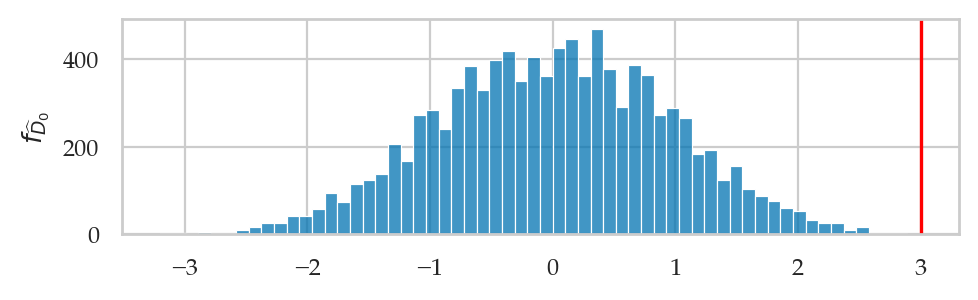

In [17]:
filename = os.path.join(DESTDIR, "hist_p-value_dmeans_eprices.pdf")

# plot the sampling distribution in blue
bins = nicebins(pdhats, obsdhat)
ax = sns.histplot(pdhats, bins=bins)

# plot red line for the observed statistic
plt.axvline(obsdhat, color="red")

# plot the values that are equal or more extreme in red
sns.histplot(tails, ax=ax, bins=bins, color="red")
ax.set_ylabel("$f_{\widehat{D}_0}$")

savefigure(ax, filename)

#### Effect size estimates

The bootstrap confidence interval for the effect size 
$\ci{\Delta,0.9}^*$ tells us a range of plausible values for the effect size.

In [18]:
from stats_helpers import ci_dmeans

np.random.seed(45)
ci_dmeans(pricesW, pricesE, alpha=0.1, method="b")

[2.0777777777777775, 3.9555555555555557]

The 90% confidence interval $\ci{\Delta,0.9}^* = [2.08, 3.96]$ describes an interval of numbers
that should contain the difference between group means $\Delta$ at least 90\% of the time:

$$
    \textrm{Pr}_{\mathbf{X}}\big(\{ \Delta \in \ci{\Delta,0.9}^* \}\big) \geq 0.9.
$$


In [19]:
## Bootstrap difference between means under the hood
# from scipy.stats import bootstrap
# np.random.seed(45)
# res = bootstrap((pricesW, pricesE), statistic=dmeans,
#                 vectorized=False, confidence_level=0.9,
#                 n_resamples=10000, method='percentile')
# [res.confidence_interval.low,
#  res.confidence_interval.high]

### Reusable function

In [20]:
def permutation_test_dmeans(xsample, ysample, P=10000):
    # 1. Compute the observed difference between means
    obsdhat = dmeans(xsample, ysample)

    # 2. Get sampling dist. of `dmeans` under H0
    pdhats = []
    for i in range(0, P):
        psx, psy = resample_under_H0(xsample, ysample)
        pdhat = dmeans(psx, psy)
        pdhats.append(pdhat)

    # 3. Compute the p-value
    tails = tailvalues(pdhats, obsdhat)
    pvalue = len(tails) / len(pdhats)
    return pvalue

In [21]:
np.random.seed(42)

permutation_test_dmeans(pricesW, pricesE)

0.0002

### Using existing SciPy functions (optional)

#### Permutations test using `ttest_ind`

You can use the SciPy implementation of permutation test,
by calling `ttest_ind(..., permutations=10000)` to perform a permutation test, then obtain the $p$-value.

In [22]:
from scipy.stats import ttest_ind

np.random.seed(42)
ttest_ind(pricesW, pricesE, permutations=10000).pvalue

0.00029997000299970003

Note the $p$-value we obtained form the two methods may be different.
This can happen when using the permutations test,
because we use randomness as part of the calculation.

### Example 6: lecture and debate curriculums

In [23]:
students = pd.read_csv("../datasets/students.csv")
# students

In [24]:
students.groupby("curriculum")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
curriculum,,,,,,,,
debate,8.0,76.462500,10.519633,62.9,69.55,75.55,80.925,96.2
lecture,7.0,68.142857,7.758406,57.0,63.30,70.30,73.850,75.4


In [25]:
scoresD = students[students["curriculum"]=="debate"]["score"]
scoresL = students[students["curriculum"]=="lecture"]["score"]

# observed difference between score means
dhat = dmeans(scoresD, scoresL)
dhat

8.319642857142853

Our goal is to determine how *likely* or *unlikely* this observed value $\hat{d}_s=8.32$ is under the null hypothesis $H_0$. This means we need to obtain the sampling distribution of $\hat{D}_0$ under $H_0$, which we can do using the permutation test.

In [26]:
np.random.seed(43)
pvalue = permutation_test_dmeans(scoresD, scoresL)
pvalue

0.1118

Saved figure to figures/stats/two_sample_tests/hist_p-value_dmeans_students.pdf
Saved figure to figures/stats/two_sample_tests/hist_p-value_dmeans_students.png


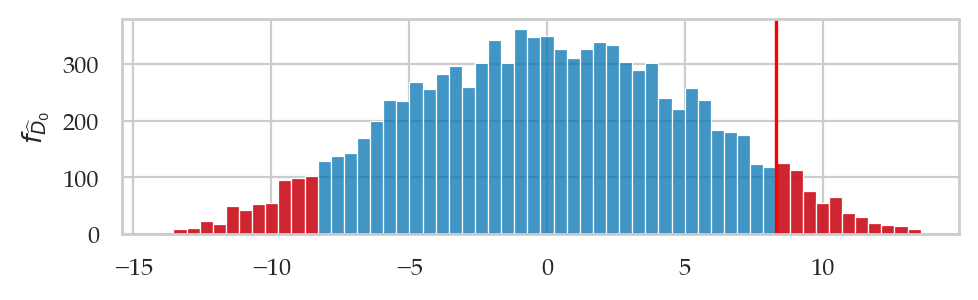

In [27]:
filename = os.path.join(DESTDIR, "hist_p-value_dmeans_students.pdf")

# generate sampling distribution under H0
np.random.seed(43)
pdhats = []
P = 10000
for i in range(0, P):
    rs1, rs2 = resample_under_H0(scoresD, scoresL)
    pdhat = dmeans(rs1, rs2)
    pdhats.append(pdhat)
    
# plot the sampling distribution in blue
bins = nicebins(pdhats, dhat)
ax = sns.histplot(pdhats, bins=bins)

# plot red line for the observed statistic
plt.axvline(dhat, color="red")

# plot the values that are equal or more extreme in red
tails = tailvalues(pdhats, dhat)
# print( len(tails) / len(pdhats) )
sns.histplot(tails, bins=bins, ax=ax, color="red")
ax.set_ylabel("$f_{\widehat{D}_0}$")

savefigure(ax, filename)

## Analytical approximation for comparing two groups


We'll now look at another approach for answering Question 1:
using and analytical approximation,
which is the way normally taught in STATS 101 courses.
How likely or unlikely is the observed difference $d=130$ under the null hypothesis?

- Analytical approximations are math models for describing the sampling distribution under $H_0$
  - Real sampling distributions: obtained by repeated sampling from $H_0$
  - Analytical approximation: probability model based on estimated parameters
- Based on this assumption we can use the theoretical model for the difference between group means
  that we developed earlier, we can obtain a **closed form expression** for the sampling distribution of $D$.
- In particular, the probability model for the two groups under $H_0$ are:
  
  $$ 
       H_0: \qquad X = \mathcal{N}(\color{red}{\mu_0}, \sigma_X)
       \quad \textrm{and} \quad
       Y = \mathcal{N}(\color{red}{\mu_0}, \sigma_Y), \quad
  $$
  
  from which we can derive the model for $D = \overline{\mathbf{X}} - \overline{\mathbf{Y}}$:
  
  $$ 
     D  \sim \mathcal{N}\!\left( \color{red}{0}, \  \sqrt{ \tfrac{\sigma^2_X}{n} + \tfrac{\sigma^2_Y}{m} } \right)
  $$
  
  In words, the sampling distribution of the difference between group means is
  normally distributed with mean $\mu_D = 0$ and standard deviation $\sigma_D$,
  which depends on the variance of the two groups $\sigma^2_S$ and $\sigma^2_{NS}$.
  Recall we obtained this expression earlier when we discussed difference of means between groups A and B.
- However, the population variances $\sigma^2_S$ and $\sigma^2_{NS}$ are unknown,
  and we only have the estimated variances $s_S^2$ and $s_{NS}^2$,
  which we calculated from the sample.
- That's OK though, since the sample variances are estimates for the population variances.
  There are two common ways to obtain an approximation for $\sigma^2_D$:
  - Unpooled variance: $\sigma^2_D \approx s^2_u = \tfrac{s^2_S}{n_S} + \tfrac{s^2_{NS}}{n_{NS}}$
    (follows from the general rule of probability theory)
  - Pooled variance: $\sigma^2_D \approx s^2_p =  \frac{(n_S-1)s_S^2 \; + \; (n_{NS}-1)s_{NS}^2}{n_S + n_{NS} - 2}$
    (takes advantage of assumption that both samples come from the same population under $H_0$)
- NEW CONCEPT: **Student's $t$-distribution** is a model for $D$ which takes into account
  we are using $s_S^2$ and $s_{NS}^2$ instead of $\sigma_S^2$ and $\sigma_{NS}^2$.
- NEW CONCEPT: **degrees of freedom**, denoted `df` in code or $\nu$ (Greek letter *nu*) in equations,
  is the parameter of Student's $t$-distribution dependent on the sample size used to estimate quantities.


### Example 5T: comparing East and West electricity prices

In [28]:
eprices = pd.read_csv("../datasets/eprices.csv")
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

# Calculate the observed difference between means
dprices = dmeans(pricesW, pricesE)
dprices

3.0

#### Welch's t-test (unpooled variances)

We'll now show the [$t$-test](https://statkat.com/stattest.php?&t=9) procedure
known as Welch's t-test,
which allows the variances in the two groups to be different.

We'll talk about the $t$-test with pooled variances later on.

Welch's $t$-test differs only in steps 4 through 6 as shown below:

In [29]:
# Calculate the sample size and the standard deviation for each group
nW, nE = len(pricesW), len(pricesE)
stdW, stdE = std(pricesW), std(pricesE)

In [30]:
# Compute the standard error of the estimator D (Welch's t-test)
seD = np.sqrt(stdW**2/nW + stdE**2/nE)
seD

0.5972674401486561

In [31]:
from stats_helpers import calcdf
    
# Obtain the degrees of freedom from the crazy formula
df = calcdf(stdW, nW, stdE, nE)
df

12.59281702723103

In [32]:
# Compute the value of the t-statistic
obst = (dprices - 0) / seD

In [33]:
from stats_helpers import tailprobs
# Calculate the p-value

from scipy.stats import t as tdist
rvT0 = tdist(df)
pvalue = tailprobs(rvT0, obst, alt="two-sided")
pvalue

0.0002570338337217614

In [34]:
# # SKIP BECAUSE TOO SMALL
# filename = os.path.join(DESTDIR, "rvT0_p-value_dmeans_eprices.pdf")
# from plot_helpers import calc_prob_and_plot_tails
# _, ax = calc_prob_and_plot_tails(rvT0, -obst, obst, xlims=[-4,4])
# ax.set_title(None)
# ax.set_xlabel("$t$")
# ax.set_ylabel("$f_{T_0}$")
# savefigure(ax, filename)

#### T-test with pooled variances

In [35]:
# Compute the pooled variance and standard error of estimator D
pooled_var = ((nW-1)*stdW**2 + (nE-1)*stdE**2) / (nW + nE - 2)
pooled_std = np.sqrt(pooled_var)
pooled_seDprices = pooled_std * np.sqrt(1/nW + 1/nE)

In [36]:
# Obtain the degrees of freedom
df2 = nW + nW - 2
df2

16

In [37]:
# Compute the value of the t-statistic
obst2 = (dprices - 0) / pooled_seDprices

In [38]:
from stats_helpers import tailprobs

# Calculate the p-value
rvT2 = tdist(df2)
pvalue2 = tailprobs(rvT2, obst2, alt="two-sided")
pvalue2

0.0001249706798767125

#### Reusable procedure for two-sample $t$-test

In [39]:
#######################################################

def ttest_dmeans(xsample, ysample, equal_var=False):
    # Calculate the observed difference between means
    obsdhat = mean(xsample) - mean(ysample)

    # Calculate the sample sizes and the stds
    n, m = len(xsample), len(ysample)
    sx, sy = std(xsample), std(ysample)

    # Calculate the standard error, the degrees of
    # freedom, the null model, and the t-statistic
    if not equal_var:  # Welch's t-test (default)
        seD = np.sqrt(sx**2/n + sy**2/m)
        df = calcdf(sx, n, sy, m)
        rvT0 = tdist(df)
        obst = (obsdhat - 0) / seD
    else:              # Use pooled variance
        varp = ((n-1)*sx**2 + (m-1)*sy**2) / (n+m-2)
        stdp = np.sqrt(varp)
        seDp = stdp * np.sqrt(1/n + 1/m)
        dfp = n + m - 2
        rvT0 = tdist(dfp)
        obst = (obsdhat - 0) / seDp

    # Calculate the p-value from the t-distribution
    pvalue = tailprobs(rvT0, obst, alt="two-sided")
    return pvalue


Verify we get the same $p$-value
when using the standard error formula.

In [40]:
ttest_dmeans(pricesW, pricesE)

0.0002570338337217614

Verify we get the same $p$-value
when using the pooled variance formula.

In [41]:
ttest_dmeans(pricesW, pricesE, equal_var=True)

0.0001249706798767125

##### Alternatively use `scipy.stats.ttest_ind` (OPTIONAL)

In [42]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
result1 = ttest_ind(pricesW, pricesE, equal_var=False)
result1.pvalue

0.0002570338337217609

In [43]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
result2 = ttest_ind(pricesW, pricesE, equal_var=True)
result2.pvalue

0.00012497067987678488

### Example 6T: comparing rural and urban sleep scores

In [44]:
students = pd.read_csv("../datasets/students.csv")
# students
# students.groupby("curriculum")["score"].describe()

scoresD = students[students["curriculum"]=="debate"]["score"]
scoresL = students[students["curriculum"]=="lecture"]["score"]

# observed difference between score means
dhat = dmeans(scoresD, scoresL)
dhat

8.319642857142853

In [45]:
ttest_dmeans(scoresD, scoresL)

0.10307495448387442

0.10307495448387442
Saved figure to figures/stats/two_sample_tests/rvT0_p-value_dmeans_sleepscores.pdf
Saved figure to figures/stats/two_sample_tests/rvT0_p-value_dmeans_sleepscores.png


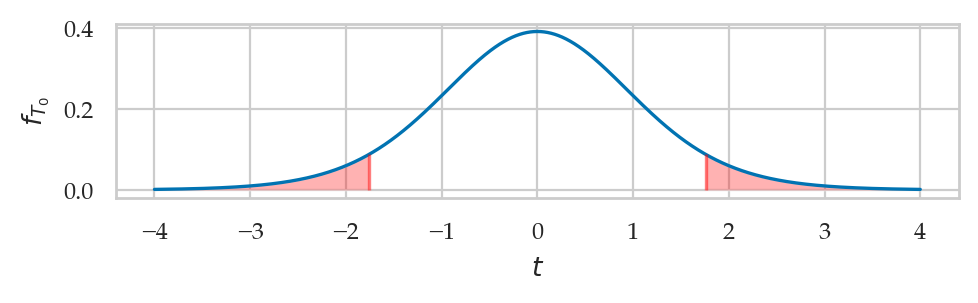

In [46]:
filename = os.path.join(DESTDIR, "rvT0_p-value_dmeans_sleepscores.pdf")

nD, nL = len(scoresD), len(scoresL)
stdD, stdL = std(scoresD), std(scoresL)
seDDL = np.sqrt(stdD**2/nD + stdL**2/nL)

from stats_helpers import calcdf
dfDL = calcdf(stdD, nD, stdL, nL)
rvT0DL = tdist(dfDL)
obstDL = (dhat - 0) / seDDL
pvalueDL = tailprobs(rvT0DL, obstDL, alt="two-sided")
print(pvalueDL)

from plot_helpers import calc_prob_and_plot_tails
_, ax = calc_prob_and_plot_tails(rvT0DL, -obstDL, obstDL, xlims=[-4,4])
ax.set_title(None)
ax.set_xlabel("$t$")
ax.set_ylabel("$f_{T_0}$")
savefigure(ax, filename)

In [47]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
result = ttest_ind(scoresD, scoresL, equal_var=False)
result.pvalue

0.10307495448387395

## Explanations

### Two-sided tests

Saved figure to figures/stats/two_sample_tests/panel_D0_and_T0_twosided_pvalues.pdf
Saved figure to figures/stats/two_sample_tests/panel_D0_and_T0_twosided_pvalues.png


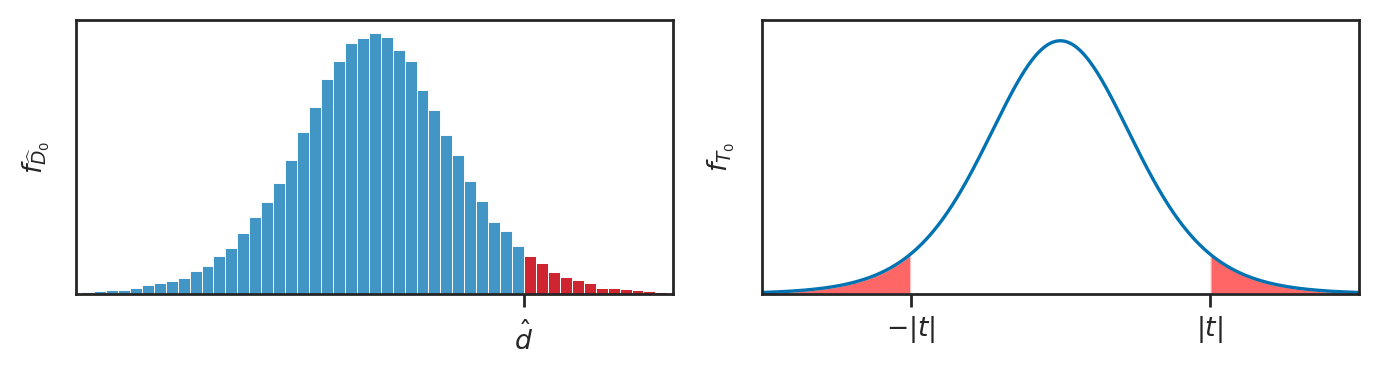

In [48]:
filename = os.path.join(DESTDIR, "panel_D0_and_T0_twosided_pvalues.pdf")

from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

N = 100000
np.random.seed(42)
ts = rvT.rvs(N)

bins = nicebins(xs, 2, nbins=50)


with plt.rc_context({"figure.figsize":(7,2)}), sns.axes_style("ticks"):
    fig, (ax1, ax2) = plt.subplots(1,2)

    # TODO: redo as continuous distribution
    # D0
    sns.histplot(ts, ax=ax1, bins=bins)
    # ax1.set_xlabel("$\hat{d}$")
    ax1.set_xlim(-4, 4)
    ax1.set_xticks([2])
    ax1.set_xticklabels([])
    ax1.set_yticks([])
    ax1.set_ylabel("$f_{\widehat{D}_0}$")
    # highlight the right tail
    tailvaluesa = [t for t in ts if t >= 2]
    sns.histplot(tailvaluesa, bins=bins, ax=ax1, color="red")
    ax1.text(2, -630, "$\hat{d}$", verticalalignment="top", horizontalalignment="center")
    # ax1.axvline(2, color="red")


    # T0
    sns.lineplot(x=xs, y=ys, ax=ax2)
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(0, 0.42)
    ax2.set_xticks([-2,2])
    ax2.set_xticklabels([])
    ax2.set_yticks([])
    ax2.set_ylabel("$f_{T_0}$")

    # highlight the left and right tails
    mask = (xs < -2)
    ax2.fill_between(xs[mask], y1=ys[mask], alpha=0.6, facecolor="red")
    ax2.text(-2, -0.03, r"$-|t|$", verticalalignment="top", horizontalalignment="center")
    mask = (xs > 2)
    ax2.fill_between(xs[mask], y1=ys[mask], alpha=0.6, facecolor="red")
    ax2.text(2, -0.03, r"$|t|$", verticalalignment="top", horizontalalignment="center")



savefigure(fig, filename)

### Statistical modelling assumptions


- LARGEn:
- NORMAL:
- EQVAR:

### Standardized effect size

It is sometimes useful to report the effect size using a "standardized" measure for effect sizes.

Cohen's $d$ is one such measure, and it is defined as the difference between two means divided by the pooled standard deviation.

In [49]:
def cohend2(sample1, sample2):
    """
    Cohen's d measure of effect size for two independent samples.
    """
    n1, n2 = len(sample1), len(sample2)
    mean1, mean2 = mean(sample1), mean(sample2)
    var1, var2 = var(sample1), var(sample2)
    # calculate the pooled variance and std
    var_pooled = ((n1-1)*var1+(n2-1)*var2) / (n1+n2-2)
    std_pooled = np.sqrt(var_pooled)
    cohend = (mean1 - mean2) / std_pooled
    return cohend

We can interpret the value of Cohen's d obtained using the [reference table](https://en.wikipedia.org/wiki/Effect_size#Cohen's_d) of values:

| Cohen's d   | Effect size |
| ----------- | ----------- |
| 0.01        | very small  |
| 0.20        | small       |
| 0.50        | medium      |
| 0.80        | large       |


Effect size for mean deviation of kombucha Batch 04 from expected value $\mu_K=1000$.

In [50]:
cohend2(pricesW, pricesE)

2.3678062243290983

## Discussion
### Hypothesis testing using confidence intervals
### Comparison to resampling methods
### Other statistical methods

## Exercises
## Links